<a href="https://colab.research.google.com/github/Pheonix10101/PRCV_p_5/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Project 5: Recognition using Deep Networks

Author: Samruddhi Raut

This file contain following tasks
Task 1
A: Get the MNIST digit data set
B:Make your network code repeatable
C:Build a network model
D:Train the model
E:Save the network to a file
"""
#import_statements
from torchvision import transforms  #Load Dataloader, 1. transformation eg cropping/normalization 2. GPU functions
from torchvision import datasets
from matplotlib import pyplot as plt
import sys
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader


**Class defination**

In [ ]:
# class definitions
class NeuralNetwork(nn.Module):
    def __init__(self, conv_filter = 5, dropout_rate = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, (conv_filter, conv_filter))
        self.conv2 = nn.Conv2d(10, 20, (conv_filter, conv_filter))
        self.conv2_drop = nn.Dropout2d(dropout_rate)
        self.flat1 = nn.Flatten() # flatten operation, which is equal to view(-1, 320)
        outer = conv_filter // 2
        size = ((28 - 2 * outer) // 2 - 2 * outer) // 2
        self.fc1 = nn.Linear(20 * size * size, 50)
        self.fc2 = nn.Linear(50, 10)

# computes a forward pass for the network

    def forward(self, x):
        x = self.conv1(x) # A convolution layer with 10 5x5 filters
        x = F.relu(F.max_pool2d(x, (2, 2)))# A max pooling layer with a 2x2 window and a ReLU function applied
        x = self.conv2(x) # A convolution layer with 20 5x5 filters
        x = self.conv2_drop(x) # A dropout layer with a 0.5 dropout rate (50%)
        x = F.relu(F.max_pool2d(x, (2, 2))) # A max pooling layer with a 2x2 window and a ReLU function applied
        x = F.relu(self.fc1(self.flat1(x))) # A flattening operation followed by a fully connected Linear layer with 50 nodes and a ReLU function on the output
        x = F.log_softmax(self.fc2(x), dim = 1)  # A final fully connected Linear layer with 10 nodes and the log_softmax function applied to the output

        return x

**This function return the dataset read and plot the 1st 8 digits**

In [ ]:
# batch size for training and testing
BATCH_SIZE_TRAIN = 64  
BATCH_SIZE_TEST = 1000
# iterations of training
EPOCHS = 5  
# learning rate
LEARNING_RATE = 0.01  
# refers to inertia
MOMENTUM = 0.5  
# record the loss for every interval batches passed
LOG_INTERVAL = 10  

def read_and_print(batch_size_train, batch_size_test, is_show):
   
   # This function return the dataset read and plot the 1st 8 digits.
    
    # load the mnist dateset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    train_mnist = datasets.MNIST('mnist_data',train = True, download = True,transform = transform)
    test_mnist = datasets.MNIST('mnist_data',train = False,download = True,transform = transform)

    train_loader = DataLoader(dataset = train_mnist,batch_size = batch_size_train,shuffle = True,num_workers = 4)
    test_loader = DataLoader(dataset = test_mnist,batch_size = batch_size_test,shuffle = True,num_workers = 4)

    #enumerate is for loop like, but it returns indexes
    #the first enumerate statement defines the iteration
    # extract and store the date of each batches
    # elements in train_data and train_label are in type of torch.size()
    examples = enumerate(train_loader)
    train_data = []
    train_label = []
    while True:
        try:
            batch_idx, (example_data, example_label) = next(examples)
            train_data.append(example_data)
            train_label.append(example_label)
        except StopIteration:
            break

    if is_show:
        # plot the first 8 digits
        fig = plt.figure()
        i = 0
        c = 0
        while i <= (8 // BATCH_SIZE_TEST):
            for j in range(BATCH_SIZE_TEST):
                if c >= 8:
                    i = float('inf')
                    break
                plt.subplot(4, 4, c + 1)
                plt.tight_layout()
                plt.imshow(train_data[i][j][0], cmap = 'gray', interpolation = 'none')
                plt.title("GroundTruth: %d" % train_label[i][j])
                plt.xticks([])
                plt.yticks([])
                c += 1
            i += 1
        fig.show()

    return train_loader, test_loader

**This function train every batch of the training dataloader**

In [ ]:
def train_network(network, train_loader, epoch, optimizer, log_interval, train_losses, train_counter, show_process):
    
    #this function train every batch of the training dataloader
    #Parameters are:
    #Network - model of neural network
    #train_loader -dataloader of training data
    #epoch -times complete pass through the training data
    #optimizer -the function or algorithm to minimize the loss by adjusting weights or learning rate
    #log_interval- interval between every two recordings of loss
    #train_losses - value of loss at each value of training counter
    #train_counter -number of training example seen
    #show_process - determine whether the training process will be shown
    
    # set network to train
    network.train()

    # loop over every batch
  
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()# set optimizer to 0 gradient at the beginning
        output = network(data) # compute the output and calculate loss by cross entropy
        loss = F.cross_entropy(output, label)
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves

        # update parameters
        optimizer.step()
        if batch_idx % log_interval == 0:
            if show_process:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))

** This function evaluate the model on test set**

In [ ]:
def test_network(network, test_loader, test_losses, epoch, is_test_set):
 #This function evaluate the model on test set
 # Parameters are
 #network    -  model of neural network
 #test_loader - dataloader of test set
 #test_losses -  value of losses at each point in test counter
  
    # set model to eval()
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # disable gradient calculation is useful for inference, backward() will not be called in testing
        for data, target in test_loader:
            output = network(data)
            test_loss += F.cross_entropy(output, target, reduction = 'sum').item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    if epoch == 0:
        if is_test_set:
            print('Initial test on test set: Avg.loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))
        else:
            print('Initial test on training set: Avg.loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))
    else:
        if is_test_set:
            print('Test on test set after epoch {}: Avg.loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch, test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))
        else:
            print('\nTest on training set after epoch {}: Avg.loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

**this function train the model on training set epochs# times**

In [ ]:
def train_and_test(train_loader, test_loader, epochs, learning_rate, momentum, log_interval):
#this function train the model on training set epochs# times
    #parametrs are
    #train_loader       :  dataloader of training set
    #test_loader :  dataloader of testing set
    #epochs      :  times complete pass through the training data
    #learning_rate: learning rate
    #momentum     : refers to inertia
    #log_interval : interval between every two recordings of loss
   
    # ********initialize model and optimizer**********
    
    network = NeuralNetwork()
    optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)
    train_losses = []
    train_counter = []
    test_losses_training_set = []
    test_losses = []
    test_counter = [i * len(train_loader.dataset) for i in range(epochs + 1)]

    test_network(network, train_loader, test_losses_training_set, 0, False)
    test_network(network, test_loader, test_losses, 0, True)

    for epoch in range(1, epochs + 1):
        train_network(network, train_loader, epoch, optimizer, log_interval, train_losses, train_counter, True)
        test_network(network, train_loader, test_losses_training_set, epoch, False)
        test_network(network, test_loader, test_losses, epoch, True)

    torch.save(network.state_dict(), 'samruddhi_neural.pt')
    torch.save(optimizer.state_dict(), 'samruddhi_optimizer.pt')

    fig = plt.figure()
    plt.plot(train_counter, train_losses, color = 'green')
    plt.scatter(test_counter, test_losses, color = 'red', alpha = 0.75)
    plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig.show()

**main function**

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Initial test on training set: Avg.loss: 2.2914, Accuracy: 4867/60000 (8%)
Initial test on test set: Avg.loss: 2.2913, Accuracy: 732/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296381
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.294193
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.247737
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.239640
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.253605
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.161269
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.188351
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.121737
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.010449
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.935846
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.657381
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.537853
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.156903
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.130023
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.977066
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.008712
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.033936
Train Epoch: 1 [10880/60000 (18%)]	

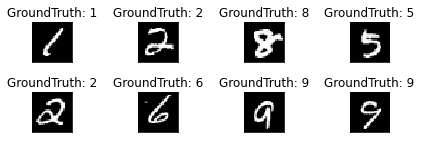

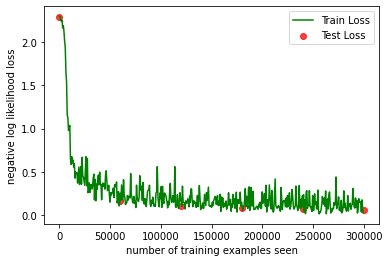

In [ ]:
# main function
def main(argv):# handle any command line arguments in argv
    
    # set the random seed
    torch.manual_seed(42)
    cudnn.enabled = False

    train_loader, test_loader = read_and_print(BATCH_SIZE_TRAIN, BATCH_SIZE_TEST, True)  # print the 1st 8 digits accordingly and return dataloader of training set and testing set
 
    train_and_test(train_loader, test_loader, EPOCHS, LEARNING_RATE, MOMENTUM, LOG_INTERVAL)    # train and test the network epochs by epochs

    #E:Save the network to a file
    torch.save(NeuralNetwork, 'samruddhi_CNN.h5')



if __name__ == "__main__":
    main(sys.argv)